In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv(r"C:/Users/Dell/Desktop/stock market pred research paper/model/datasets/CAC40_stocks_2010_2021.csv")

# Display basic info
print("Shape:", df.shape)
print("Columns:", df.columns)
print("Missing values:\n", df.isnull().sum())

# Drop any missing values
df.dropna(inplace=True)

# ✅ Filter for a specific stock (use StockName column)
# Example: 'FTI' for TechnipFMC — change this as needed
stock_name = 'FTI'
stock_df = df[df['StockName'] == stock_name].copy()

# Convert 'Date' column to datetime and set as index
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.set_index('Date', inplace=True)

# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = stock_df[features]

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)

# Create sequences (60-day window to predict next day Close)
def create_sequences(dataset, target_col, window_size=60):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i])
        y.append(dataset[i, target_col])  # e.g., Close column index
    return np.array(X), np.array(y)

# Get index of 'Close' column
target_col_index = features.index('Close')

# Generate sequences
X, y = create_sequences(scaled_data, target_col_index, window_size=60)

# Print shapes
print("X shape:", X.shape)  # (samples, 60, 5)
print("y shape:", y.shape)

# Split into train/test (80/20), no shuffling to preserve time order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Shape: (81735, 8)
Columns: Index(['CompanyName', 'StockName', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Date'],
      dtype='object')
Missing values:
 CompanyName    0
StockName      0
High           0
Low            0
Open           0
Close          0
Volume         0
Date           0
dtype: int64
X shape: (2729, 60, 5)
y shape: (2729,)
Train shapes: (2183, 60, 5) (2183,)
Test shapes: (546, 60, 5) (546,)


Plotting for: FTI


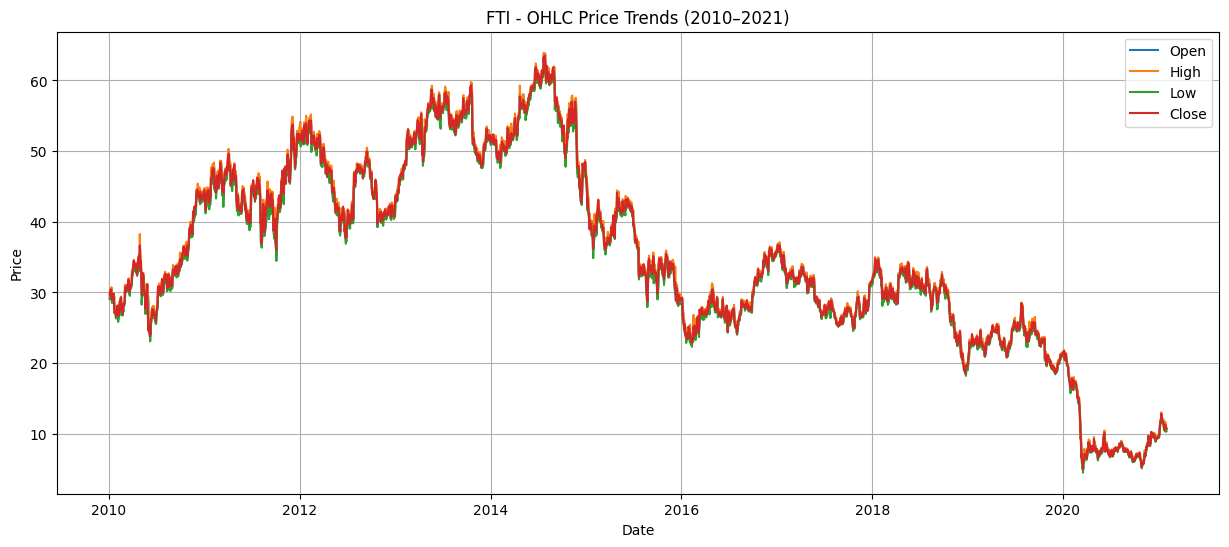

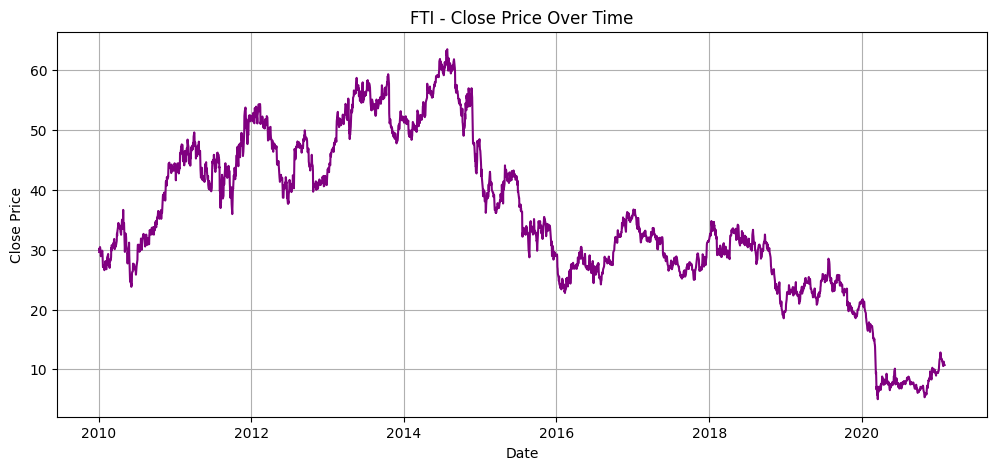

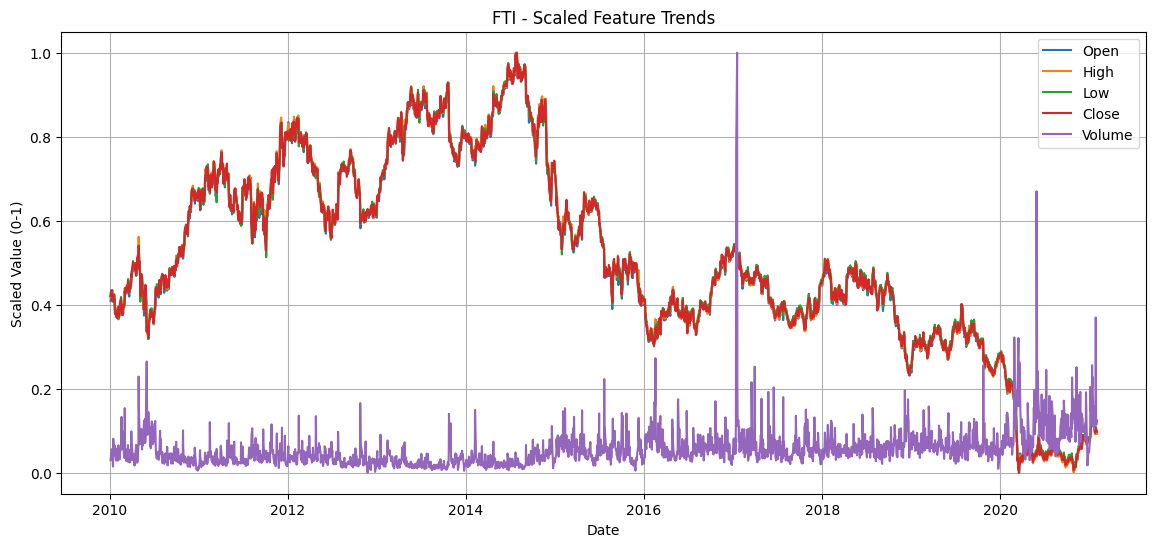

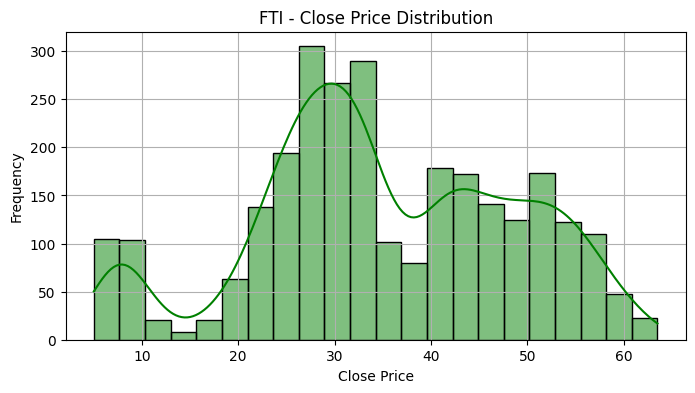

In [4]:
import seaborn as sns

# Restore original (unscaled) stock_df
print("Plotting for:", stock_name)

# 1. Plot all OHLCV features
plt.figure(figsize=(15, 6))
for col in ['Open', 'High', 'Low', 'Close']:
    plt.plot(stock_df.index, stock_df[col], label=col)
plt.title(f"{stock_name} - OHLC Price Trends (2010–2021)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# 2. Close Price Only
plt.figure(figsize=(12, 5))
plt.plot(stock_df.index, stock_df['Close'], color='purple')
plt.title(f"{stock_name} - Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

# 3. Scaled Features Plot
plt.figure(figsize=(14, 6))
for feature in features:
    plt.plot(scaled_df.index, scaled_df[feature], label=feature)
plt.title(f"{stock_name} - Scaled Feature Trends")
plt.xlabel("Date")
plt.ylabel("Scaled Value (0-1)")
plt.legend()
plt.grid(True)
plt.show()

# 4. Target (Close) Distribution
plt.figure(figsize=(8, 4))
sns.histplot(stock_df['Close'], kde=True, color='green')
plt.title(f"{stock_name} - Close Price Distribution")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
LSTM extracted features shape: (2183, 64)
🔍 SVR on LSTM Features - RMSE: 0.0289, R²: 0.9469


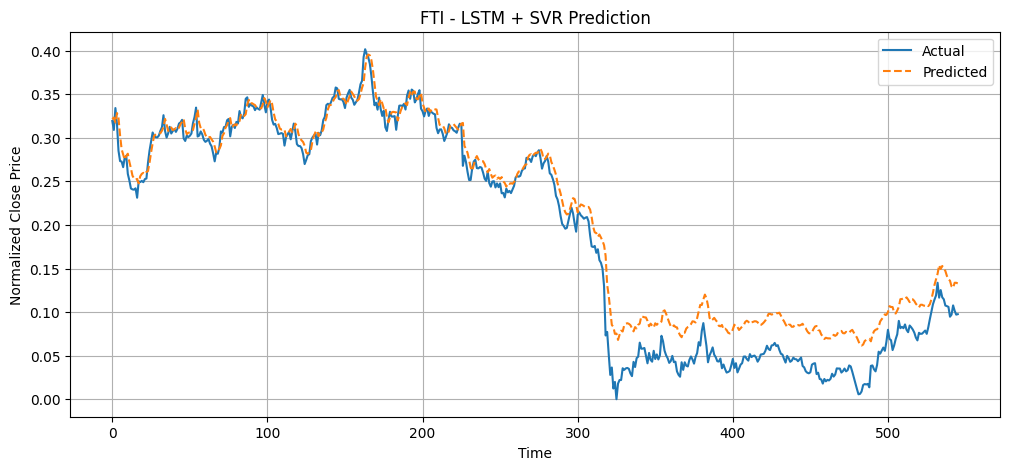

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 1: Define the LSTM model (no output layer)
def build_lstm_feature_extractor(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
    ])
    return model

# Build model and extract features
lstm_model = build_lstm_feature_extractor((X_train.shape[1], X_train.shape[2]))

# Extract features using LSTM
X_train_features = lstm_model.predict(X_train)
X_test_features = lstm_model.predict(X_test)

print("LSTM extracted features shape:", X_train_features.shape)

# Step 2: Train SVR on LSTM features
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svr.fit(X_train_features, y_train)

# Predict on test set
y_pred = svr.predict(X_test_features)

# Step 3: Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"🔍 SVR on LSTM Features - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Step 4: Plot predicted vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted", linestyle='--')
plt.title(f"{stock_name} - LSTM + SVR Prediction")
plt.xlabel("Time")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/100


C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0523 - val_loss: 8.3799e-04
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0038 - val_loss: 3.1227e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0035 - val_loss: 3.6311e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0033 - val_loss: 5.0454e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0030 - val_loss: 4.2437e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0029 - val_loss: 3.8865e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0027 - val_loss: 2.6680e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0027 - val_loss: 2.8158e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0027 - val_loss: 2.7484e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0026 - val_loss: 4.7134e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0026 - val_loss: 3.2607e-04
Epoch 12/100
62/62 ━

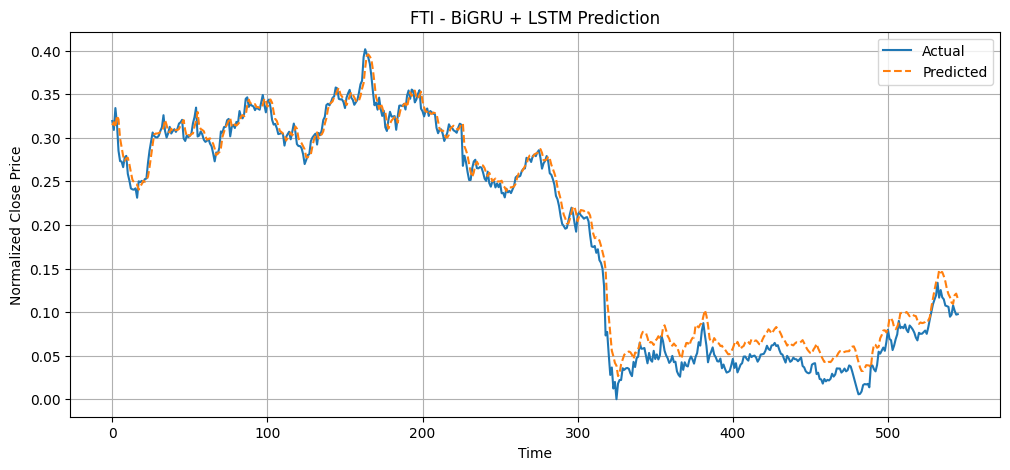

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
def build_bigru_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train the model
model = build_bigru_lstm_model((X_train.shape[1], X_train.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"🔍 BiGRU + LSTM - RMSE: {rmse:.4f}, R²: {r2:.4f}")
# Plot predicted vs actual
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted", linestyle='--')
plt.title(f"{stock_name} - BiGRU + LSTM Prediction")
plt.xlabel("Time")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0: Gen Loss = 49.1807, Disc Loss = 100.4818
Epoch 10: Gen Loss = 47.8293, Disc Loss = 95.6968
Epoch 20: Gen Loss = 47.5600, Disc Loss = 95.8036
Epoch 30: Gen Loss = 47.8582, Disc Loss = 95.7975
Epoch 40: Gen Loss = 47.8791, Disc Loss = 95.7661
Epoch 50: Gen Loss = 47.7177, Disc Loss = 95.7725
Epoch 60: Gen Loss = 47.6851, Disc Loss = 95.7714
Epoch 70: Gen Loss = 47.6946, Disc Loss = 95.7711
Epoch 80: Gen Loss = 48.2833, Disc Loss = 95.7262
Epoch 90: Gen Loss = 47.7595, Disc Loss = 95.7251
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
🔍 GAN + Transformer - RMSE: 0.7230, R²: -32.2307


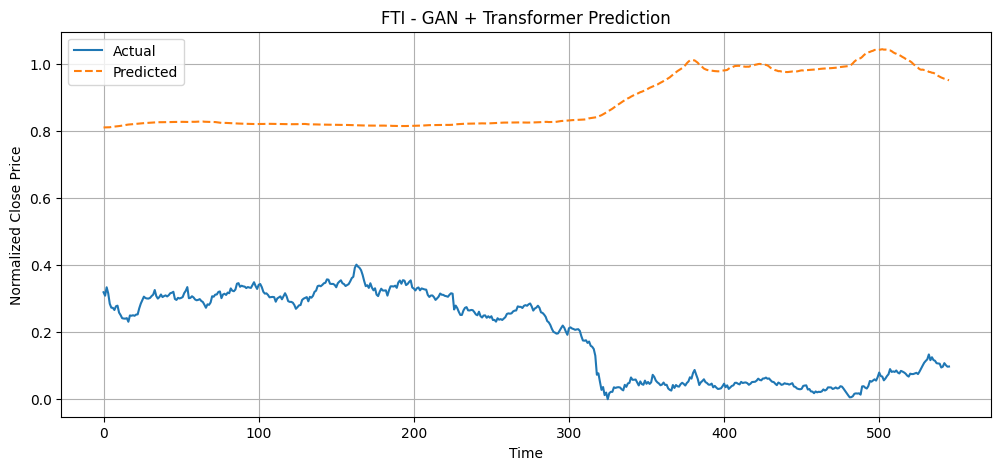

In [9]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense, Layer
import tensorflow as tf

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_generator(seq_len, n_features):
    inputs = tf.keras.Input(shape=(seq_len, n_features))

    # Project input to embedding dimension (64)
    x = Dense(64)(inputs)

    # Transformer block
    x = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(x)

    # Global pooling and output
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1)(x)

    return tf.keras.Model(inputs, x, name="Transformer_Generator")


def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

import numpy as np
from tensorflow.keras.optimizers import Adam

generator = build_generator(X_train.shape[1], X_train.shape[2])
discriminator = build_discriminator(1)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
g_optimizer = Adam(1e-4)
d_optimizer = Adam(1e-4)

BATCH_SIZE = 32
EPOCHS = 100

@tf.function
def train_step(real_x, real_y):
    noise = real_x  # Use actual sequences as input noise for generator

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_y = generator(noise, training=True)

        real_output = discriminator(real_y, training=True)
        fake_output = discriminator(generated_y, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
for epoch in range(EPOCHS):
    gen_loss, disc_loss = 0, 0
    for i in range(0, len(X_train), BATCH_SIZE):
        X_batch = X_train[i:i + BATCH_SIZE]
        y_batch = y_train[i:i + BATCH_SIZE].reshape(-1, 1)
        gl, dl = train_step(X_batch, y_batch)
        gen_loss += gl
        disc_loss += dl
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Gen Loss = {gen_loss.numpy():.4f}, Disc Loss = {disc_loss.numpy():.4f}")

# Predict using the Generator
y_pred = generator.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"🔍 GAN + Transformer - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted", linestyle='--')
plt.title(f"{stock_name} - GAN + Transformer Prediction")
plt.xlabel("Time")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.grid(True)
plt.show()

